# Visualizing Patches: VGG16

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Dense, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Sample Test Image

(224, 224, 3)

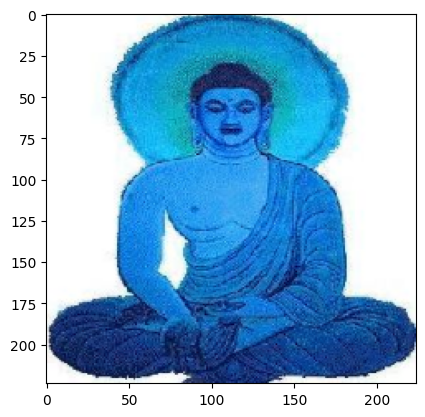

In [3]:
image = cv2.imread('image_0002.jpg')
image = cv2.resize(image, (224, 224))
plt.imshow(image, cmap='gray')

image.shape

### Load Model

In [4]:
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 3s 0us/step


### Summary

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Testing

In [6]:
test = np.expand_dims(image, axis=0)
test.shape

(1, 224, 224, 3)

### Traceback

In [7]:
def get_feature(layer_name, test):
  layer_outputs = [layer.output for layer in model.layers if layer.name == layer_name]
  activation_model = Model(inputs=model.input, outputs=layer_outputs)
  return activation_model.predict(test)

##### Plotting one example

In [8]:
last_conv = get_feature('block5_conv3' , test)

1/1 [==============================] - 1s 783ms/step


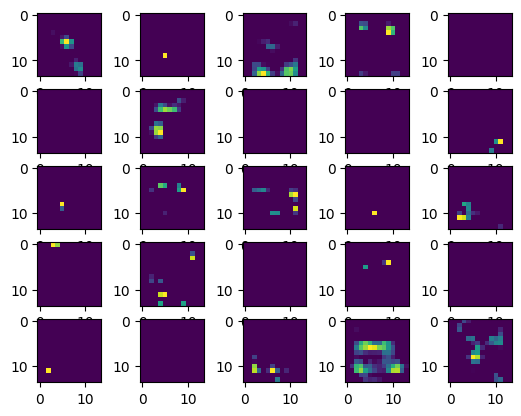

In [9]:
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(np.squeeze(last_conv[:, :, :, i]))
plt.show()

##### Finding Maximally activated neuron in final conv layer

In [10]:
max_pos = np.argmax(np.squeeze(last_conv[:, :, :, 1]))
max_pos

131

In [11]:
np.ndarray.flatten(np.squeeze(last_conv[:, :, :, i]))[max_pos], np.amax(np.squeeze(last_conv[:, :, :, 1]))

(19.630299, 6.3415065)

##### Getting features of each layer w/o gradients

I am starting with last conv layer. block5conv3 only used for this code. rest just written for ur clarity. So dont get confused.

In [12]:
block5conv3 = get_feature('block5_conv3', test) # Only this layer is used for our assignment
block5conv2 = get_feature('block5_conv2', test)
block5conv1 = get_feature('block5_conv1', test)

block5_pool = get_feature('block5_pool', test)

block4conv3 = get_feature('block4_conv3', test)
block4conv2 = get_feature('block4_conv2', test)
block4conv1 = get_feature('block4_conv1', test)

block4_pool = get_feature('block4_pool', test)

block3conv2 = get_feature('block3_conv2', test)
block3conv1 = get_feature('block3_conv1', test)

block3_pool = get_feature('block3_pool', test)

block2conv2 = get_feature('block2_conv2', test)
block2conv1 = get_feature('block2_conv1', test)

block2_pool = get_feature('block2_pool', test)

block1conv2 = get_feature('block1_conv2', test)
block1conv1 = get_feature('block1_conv1', test)

block1_pool = get_feature('block1_pool', test)

1/1 [==============================] - 1s 569ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 190ms/step


##### Verifying shapes

In [90]:
block5conv3.shape, block5conv2.shape, block5conv1.shape,  block5_pool.shape

((1, 14, 14, 512), (1, 14, 14, 512), (1, 14, 14, 512), (1, 7, 7, 512))

In [91]:
block4conv3.shape, block4conv2.shape, block4conv1.shape,  block4_pool.shape

((1, 28, 28, 512), (1, 28, 28, 512), (1, 28, 28, 512), (1, 14, 14, 512))

In [92]:
block3conv2.shape, block3conv1.shape,  block3_pool.shape

((1, 56, 56, 256), (1, 56, 56, 256), (1, 28, 28, 256))

In [93]:
block2conv2.shape, block2conv1.shape,  block2_pool.shape

((1, 112, 112, 128), (1, 112, 112, 128), (1, 56, 56, 128))

In [94]:
block1conv2.shape, block1conv1.shape,  block1_pool.shape

((1, 224, 224, 64), (1, 224, 224, 64), (1, 112, 112, 64))

##### Back tracing last three conv layers (Note the strides and padding)

In [94]:
def trace_patch1(max_pos):
  '''
  This is for stride 1 and padding 1 and (3*3 filter size)
  Written in a most shit way, you can generalize it further.
  '''
  #order matters
  pos = [(max_pos[0]-1, max_pos[1]-1), (max_pos[0], max_pos[1]-1), (max_pos[0]+1, max_pos[1]-1),
              (max_pos[0]-1, max_pos[1]), (max_pos[0], max_pos[1]), (max_pos[0]+1, max_pos[1]), 
              (max_pos[0]-1, max_pos[1]+1), (max_pos[0], max_pos[1]+1), (max_pos[0]+1, max_pos[1]+1)]

  return pos

In [95]:
#max_pos = np.argmax(np.squeeze(last_conv[:, :, :, 1]))
max_value = np.max(np.squeeze(last_conv[:, :, :, 1]))
max_pos = np.where(np.squeeze(last_conv[:, :, :, 1]) == max_value)
max_pos = (max_pos[0][0], max_pos[1][0])
max_pos

(9, 5)

In [96]:
# Strides = 1 and padding = 1 (same) in the second last Conv Layer

patch1 = trace_patch1(max_pos) # block5conv2 has (1, 14, 14, 512)

In [101]:
patch1

[(8, 4), (9, 4), (10, 4), (8, 5), (9, 5), (10, 5), (8, 6), (9, 6), (10, 6)]

In [113]:
patch2 = []
for i in patch1:
  patch2.extend(trace_patch1(i))

patch2 = list(set(patch2)) #unique positions only
print(patch2)

[(9, 5), (8, 3), (10, 6), (11, 5), (10, 3), (8, 6), (7, 4), (7, 7), (9, 7), (11, 4), (8, 5), (9, 4), (11, 7), (10, 5), (7, 3), (7, 6), (8, 4), (9, 3), (8, 7), (10, 4), (9, 6), (11, 3), (10, 7), (11, 6), (7, 5)]


##### Back tracing from conv layer to max pooling layer. (stride and padd changes here)

In [115]:
def trace_poolpatch1(max_pos):
  '''
  This is for stride 2 and padding 0 and (2*2 filter size)
  Written in a most shit way, you can generalize it further.
  '''
  filter_size = 2 # (2, 2)
  max_pos = (max_pos[0]*2, max_pos[1]*2)
  return [max_pos, (max_pos[0], max_pos[1]+1),
         (max_pos[0]+1, max_pos[1]), (max_pos[0]+1, max_pos[1]+1)]

In [116]:
patch3 = []
for i in patch2:
  patch3.extend(trace_poolpatch1(i))

patch3 = list(set(patch3)) #unique positions only
print(patch3)

[(14, 13), (17, 12), (19, 9), (15, 14), (16, 13), (18, 10), (21, 9), (22, 10), (14, 15), (17, 14), (19, 11), (15, 7), (16, 6), (16, 15), (18, 12), (20, 15), (22, 12), (14, 8), (17, 7), (15, 9), (16, 8), (18, 14), (20, 8), (22, 14), (23, 13), (14, 10), (17, 9), (19, 6), (15, 11), (16, 10), (18, 7), (20, 10), (22, 7), (23, 6), (23, 15), (14, 12), (17, 11), (15, 13), (16, 12), (18, 9), (20, 12), (22, 9), (21, 11), (23, 8), (14, 14), (19, 13), (15, 6), (16, 14), (18, 11), (20, 14), (22, 11), (21, 13), (23, 10), (14, 7), (19, 15), (16, 7), (20, 7), (21, 6), (22, 13), (21, 15), (23, 12), (14, 9), (19, 8), (16, 9), (20, 9), (22, 6), (21, 8), (23, 14), (14, 11), (17, 13), (19, 10), (15, 15), (20, 11), (22, 8), (21, 10), (23, 7), (17, 6), (17, 15), (19, 12), (15, 8), (20, 13), (18, 13), (21, 12), (23, 9), (14, 6), (17, 8), (19, 14), (15, 10), (20, 6), (18, 6), (18, 15), (21, 14), (23, 11), (22, 15), (17, 10), (19, 7), (15, 12), (16, 11), (18, 8), (21, 7)]


##### Back trace again the set of three conv layers 

In [ ]:
'''
As per VGG16 the set of conv layer has (3, 3) filters with stride 1 and padding 1,
max pool layer has (2, 2) with stride 2 and padding 0.

both has been implemented, just use those function till reaching input image.

Finally, you will have all the pixel points of the patch. just plot those wrt input image.
'''

In [ ]:
'''
Also note only the last conv layer feature is needed and no gradient is used.
'''